# Transfer Learning
### Using Model at Main Product level as baseline model and then adding more layers to predict at sub product level. An approach to check the performance of transfer learning

In [1]:
import string
import json
import re
from tqdm import tqdm
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tqdm.pandas()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words("english"))

In [6]:
users_df = pd.read_csv("/content/gdrive/My Drive/Revolut-challenge/data/complaints_users.csv")
products_df = pd.read_csv("/content/gdrive/My Drive/Revolut-challenge/data/products.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
products_df.loc[products_df.MAIN_PRODUCT == 'Payday loan', "SUB_PRODUCT"] = "Payday loan NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit reporting', "SUB_PRODUCT"] = "Credit reporting NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit card', "SUB_PRODUCT"] = "Credit card NaN"

In [0]:
df = users_df.join(products_df.set_index('PRODUCT_ID'), on='PRODUCT_ID')
# Select required columns only
cols = ['COMPLAINT_ID', 'COMPLAINT_TEXT', 'PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']
df = df[cols]

In [9]:
# Creating a dataframe with record counts for each product-id
count_df = pd.DataFrame({'COUNT': df.groupby(['PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']).size()}).reset_index()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

print(f'No. of Product Ids with less than 500 records: {count_df[count_df.COUNT < 500].shape[0]}')
count_df[count_df.COUNT < 500].head(100)

No. of Product Ids with less than 500 records: 39


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,COUNT
0,0,Bank account or service,(CD) Certificate of deposit,274
1,1,Bank account or service,Cashing a check without an account,134
5,5,Checking or savings account,CD (Certificate of Deposit),229
8,8,Checking or savings account,Personal line of credit,12
11,11,Consumer Loan,Pawn loan,34
12,12,Consumer Loan,Personal line of credit,44
13,13,Consumer Loan,Title loan,199
18,18,Credit card or prepaid card,Gift card,103
19,19,Credit card or prepaid card,Government benefit card,189
20,20,Credit card or prepaid card,Payroll card,91


In [0]:
prd_ids = list(count_df[count_df.COUNT < 500].PRODUCT_ID.values)
df = df[~df.PRODUCT_ID.isin(prd_ids)]

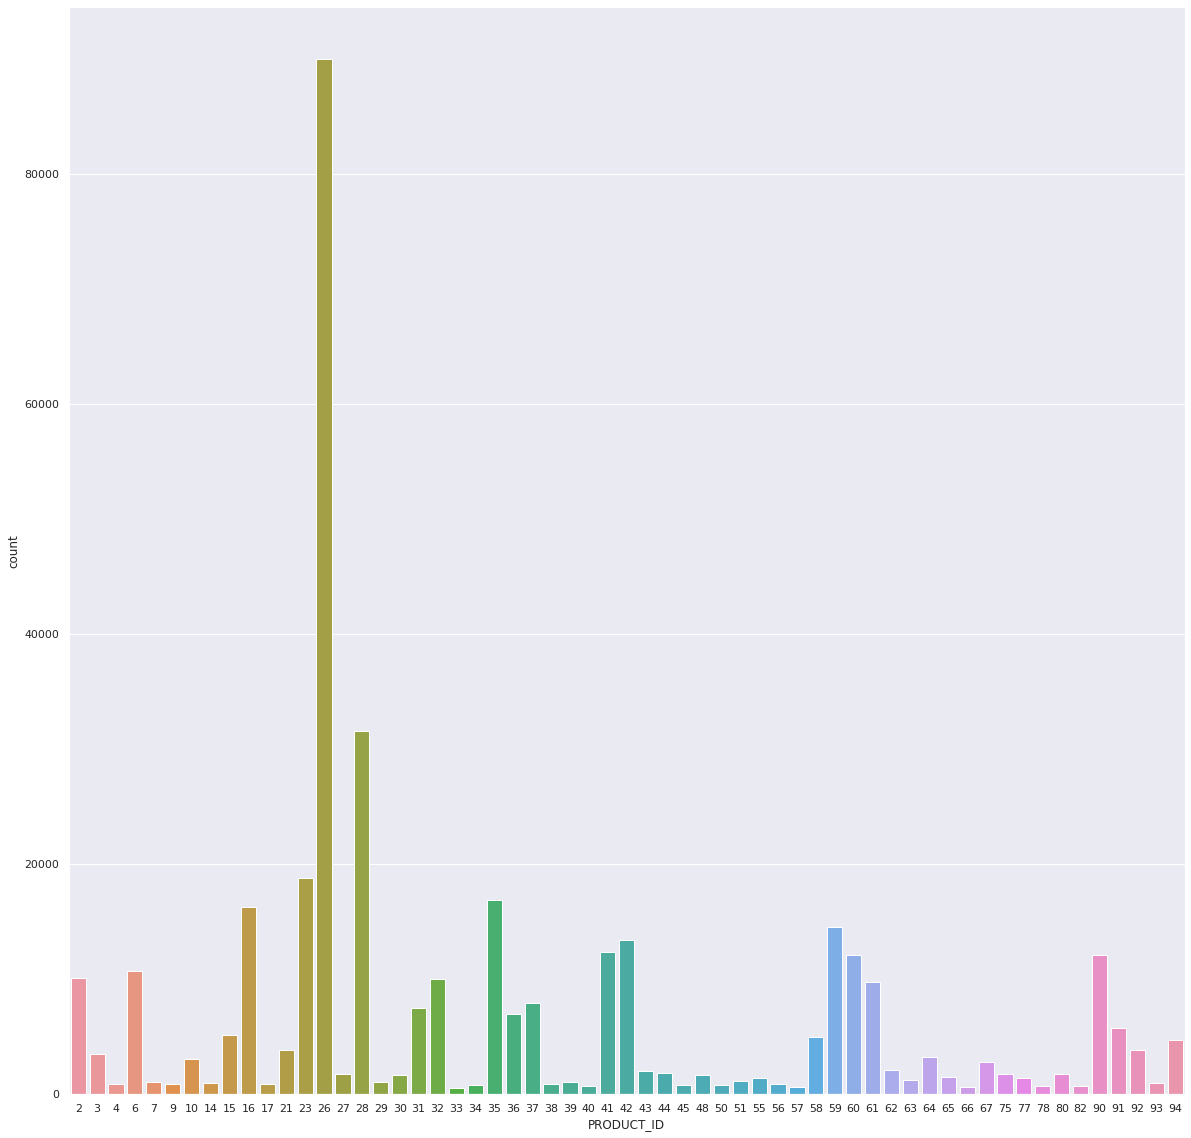

In [11]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="PRODUCT_ID", data=df)

In [12]:
df.head()

,COMPLAINT_ID,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
0,3184195,XXXX and Transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting
1,3184692,XXXX and Transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting
2,3183613,"XXXX, XXXX, and Experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting
3,3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting
4,3182218,I have a personal loan from Patriot finance. T...,26,"Credit reporting, credit repair services, or o...",Credit reporting


In [13]:
# Converting the text into lower case
def clean_text(text):
    text = text.lower()
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)"," ",text)
    text = re.sub("xxxx+", "", text)
    for word in stop_words:
        token = " " + word + " "
        text = text.replace(token, " ")
    text = re.compile(" +").sub(" ", text)
    return text
    
df.COMPLAINT_TEXT = df.COMPLAINT_TEXT.progress_map(clean_text)

100%|██████████| 379328/379328 [03:03<00:00, 2069.52it/s]


In [14]:
df.head()

,COMPLAINT_ID,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
0,3184195,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting
1,3184692,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting
2,3183613,experian need remove collection account submi...,26,"Credit reporting, credit repair services, or o...",Credit reporting
3,3182430,company inconsistencies violations double jeo...,26,"Credit reporting, credit repair services, or o...",Credit reporting
4,3182218,i personal loan patriot finance incorrectly re...,26,"Credit reporting, credit repair services, or o...",Credit reporting


In [0]:
df['PRODUCT_ID'] = df.PRODUCT_ID.astype('str')
df.set_index('COMPLAINT_ID', inplace=True)

In [0]:
sub_prd_id_dict = {}
for idx, label in enumerate(df.SUB_PRODUCT.unique()):
    sub_prd_id_dict[label] = idx

In [17]:
df['label'] = df.SUB_PRODUCT.replace(sub_prd_id_dict)
df.head()

,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,label
COMPLAINT_ID,,,,,
3184195,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3184692,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3183613,experian need remove collection account submi...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3182430,company inconsistencies violations double jeo...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3182218,i personal loan patriot finance incorrectly re...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.2,
    random_state=17,
    stratify=df.label.values
)

In [0]:
df_val_test = df.loc[X_val_test]

In [20]:
print(df_val_test.shape)
df_val_test.head()

(75866, 5)


,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,label
COMPLAINT_ID,,,,,
1982571,reporting credit bureaus repossession showing...,28,Credit reporting,Credit reporting NaN,35
2266704,avoid quicken loan working quicken va refinanc...,67,Mortgage,VA mortgage,26
1773274,i accounts different companies disputed times ...,28,Credit reporting,Credit reporting NaN,35
2942610,applied mortgage said report included dads cre...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3120464,i received notice collection dated xx xx pennc...,42,Debt collection,Other debt,4


In [0]:
X_val, X_test, y_val, y_test = train_test_split(
    df_val_test.index.values,
    df_val_test.label.values,
    test_size=0.5,
    random_state=17,
    stratify=df_val_test.label.values
)

In [0]:
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [23]:
df[['SUB_PRODUCT', 'COMPLAINT_TEXT', 'label', 'data_type']].groupby(['SUB_PRODUCT', 'data_type']).count()

COMPLAINT_TEXT  label
SUB_PRODUCT                                data_type                       
Auto                                       test                  106    106
                                           train                 851    851
                                           val                   107    107
Auto debt                                  test                  166    166
                                           train                1328   1328
                                           val                   166    166
Checking account                           test                 2082   2082
                                           train               16658  16658
                                           val                  2082   2082
Conventional adjustable mortgage (ARM)     test                  498    498
                                           train                3980   3980
                                           val                   497    497
Conventional fixed mortgage                test                 1456   1456
                                           train               11650  11650
                                           val                  1456   1456
Conventional home mortgage                 test                 1210   1210
                                           train                9678   9678
                                           val                  1210   1210
Credit card                                test                  752    752
                                           train                6016   6016
                                           val                   752    752
Credit card NaN                            test                 1884   1884
                                           train               15070  15070
                                           val                  1884   1884
Credit card debt                           test                 1002   1002
                                           train                8017   8017
                                           val                  1002   1002
Credit reporting                           test                 8999   8999
                                           train               71995  71995
                                           val                  9000   9000
Credit reporting NaN                       test                 3159   3159
                                           train               25270  25270
                                           val                  3159   3159
Domestic (US) money transfer               test                  249    249
                                           train                1998   1998
                                           val                   250    250
FHA mortgage                               test                  979    979
                                           train                7830   7830
                                           val                   979    979
Federal student loan                       test                   55     55
                                           train                 439    439
                                           val                    55     55
Federal student loan debt                  test                   80     80
                                           train                 636    636
                                           val                    79     79
Federal student loan servicing             test                 1214   1214
                                           train                9710   9710
                                           val                  1214   1214
General purpose card                       test                   73     73
                                           train                 584    584
                                           val                    73     73
General-purpose credit car

In [24]:
train_sentences = df[df.data_type == 'train'].COMPLAINT_TEXT.values
print(len(train_sentences))
print(train_sentences[0])

303462
 transunion reporting incorrectly days past due loans partial account numbers accounts reflect balance past due contacted two bureaus requested coding errors corrected incorrect reporting harming credit score impossible past due accounts balance past due 


In [25]:
validation_sentences = list(df[df.data_type == 'val'].COMPLAINT_TEXT.values)
print(len(validation_sentences))
print(validation_sentences[0])

37933
the following inquiries result identity theft authorized anyone permission ongoing extended fraud alert contacted creditors verify application xx xx xx xx tx xx xx xx xx de xx xx xx xx de xx xx xx xx de bank xx xx xx xx nv xx xx xx xx ia xx xx xx xx banks non specific nm bymailonly


In [26]:
test_sentences = list(df[df.data_type == 'test'].COMPLAINT_TEXT.values)
print(len(test_sentences))
print(test_sentences[0])

37933
i personal loan patriot finance incorrectly reporting loan derogatory status showing many days late payment agreement paying agreed account reflect 


In [0]:
train_labels = df[df.data_type == 'train'].label.values
validation_labels = df[df.data_type == 'val'].label.values
test_labels = df[df.data_type == 'test'].label.values

In [28]:
print(len(np.unique(train_labels)))
print(len(np.unique(validation_labels)))
print(len(np.unique(test_labels)))

52
52
52


In [0]:
from tensorflow.keras.utils import to_categorical
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [30]:
train_labels = encode(train_labels)
validation_labels = encode(validation_labels)
test_labels = encode(test_labels)

Shape of data (BEFORE encode): (303462,)
Shape of data (AFTER  encode): (303462, 52)

Shape of data (BEFORE encode): (37933,)
Shape of data (AFTER  encode): (37933, 52)

Shape of data (BEFORE encode): (37933,)
Shape of data (AFTER  encode): (37933, 52)



In [0]:
max_nb_words = 100000
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8
glove_dir = "/content/gdrive/My Drive/glove/glove.6B."+str(embedding_dim)+"d.txt"

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
import pickle
tokenizer_path = "/content/gdrive/My Drive/Revolut-challenge/model/tokenizer.pickle"
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
word_index = tokenizer.word_index

In [35]:
# tokenizer = Tokenizer(num_words = max_nb_words, oov_token=oov_tok)
# tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type,maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

34
200
34
200
7
200


In [0]:
val_sequences = tokenizer.texts_to_sequences(validation_sentences)
val_padded = pad_sequences(val_sequences,padding=padding_type, truncating=trunc_type,maxlen=max_length)

In [0]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,padding=padding_type, truncating=trunc_type,maxlen=max_length)

In [38]:
embeddings_index = {}
f = open(glove_dir)
print('Loading GloVe from:', glove_dir,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/gdrive/My Drive/glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    # return f1_score(labels_flat, preds_flat, average=None)
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in sub_prd_id_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [41]:
embedding_matrix.shape

(94012, 100)

In [0]:
base_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='softmax')
])

In [0]:
checkpoint_path = '/content/gdrive/My Drive/Revolut-challenge/model/model_9.h5'

In [0]:
base_model.load_weights(checkpoint_path)

In [0]:
base_model.trainable=False

In [0]:
inputs = tf.keras.Input(shape=(max_length,))
x = base_model(inputs)

In [0]:
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(52, activation="softmax")(x)

In [0]:
model1 = tf.keras.Model(inputs, outputs)

In [49]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 16)                9553920   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2176      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 52)                3380  

In [0]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [52]:
num_epochs = 100
history_1_1 = model1.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs,
                    batch_size=256,
                    validation_data=(val_padded, validation_labels))

Epoch 1/100
1186/1186 [==============================] - 25s 21ms/step - loss: 1.8946 - accuracy: 0.4251 - val_loss: 1.6846 - val_accuracy: 0.4564
Epoch 2/100
1186/1186 [==============================] - 24s 20ms/step - loss: 1.7486 - accuracy: 0.4417 - val_loss: 1.6664 - val_accuracy: 0.4583
Epoch 3/100
1186/1186 [==============================] - 24s 20ms/step - loss: 1.7364 - accuracy: 0.4453 - val_loss: 1.6514 - val_accuracy: 0.4587
Epoch 4/100
1186/1186 [==============================] - 24s 20ms/step - loss: 1.7268 - accuracy: 0.4457 - val_loss: 1.6465 - val_accuracy: 0.4587
Epoch 5/100
1186/1186 [==============================] - 24s 20ms/step - loss: 1.7218 - accuracy: 0.4466 - val_loss: 1.6405 - val_accuracy: 0.4616
Epoch 6/100
1186/1186 [==============================] - 24s 20ms/step - loss: 1.7171 - accuracy: 0.4469 - val_loss: 1.6376 - val_accuracy: 0.4627
Epoch 7/100
1186/1186 [==============================] - 24s 20ms/step - loss: 1.7146 - accuracy: 0.4474 - val_loss: 1

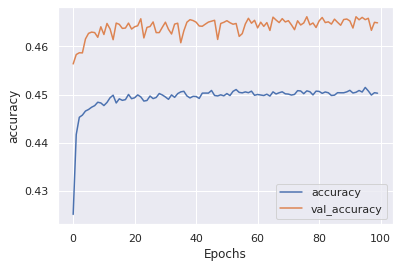

In [57]:
plot_graphs(history_1_1, 'accuracy')

In [0]:
plot_graphs(history_1_1, 'loss')

In [59]:
predictions = model1.predict(test_padded)
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: Credit reporting
Accuracy: 7309/8999

Class: Medical debt
Accuracy: 0/790

Class: Mortgage debt
Accuracy: 11/111

Class: Federal student loan servicing
Accuracy: 1031/1214

Class: Other debt
Accuracy: 152/1338

Class: Store credit card
Accuracy: 0/384

Class: Conventional home mortgage
Accuracy: 37/1210

Class: I do not know
Accuracy: 1223/1688

Class: Credit card debt
Accuracy: 50/1002

Class: Private student loan debt
Accuracy: 0/80

Class: Other banking product or service
Accuracy: 0/104

Class: Checking account
Accuracy: 1901/2082

Class: Payday loan debt
Accuracy: 0/183

Class: Private student loan
Accuracy: 0/389

Class: Domestic (US) money transfer
Accuracy: 102/249

Class: FHA mortgage
Accuracy: 0/979

Class: Federal student loan debt
Accuracy: 0/80

Class: General-purpose credit card or charge card
Accuracy: 772/1625

Class: Home equity loan or line of credit (HELOC)
Accuracy: 0/123

Class: Other personal consumer report
Accuracy: 0/176

Class: Other type of mortgage
Ac

In [60]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.39660626675622024


# Overall very poor performance :(
The current model is performing really poor at sub product level because of data imbalances. Requires more feature engineering like upsampling techniques to improve performances.